In [60]:
import math
import numpy as np
from copy import deepcopy
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx('float64')

In [61]:
# =======================
def calc_pdf(y, mu, var):
    """Calculate component density"""
    value = tf.subtract(y, mu)**2
    value = (1/tf.math.sqrt(2 * np.pi * var)) * tf.math.exp((-1/(2*var)) * value)
    return value

# =======================
def mdn_loss(y_true, pi, mu, var):
    """MDN Loss Function"""
    out = calc_pdf(y_true, mu, var)
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    return tf.reduce_mean(out)

# =======================
def create_book_example(n):
    X = np.random.uniform(0., 1., (n,1))
    y = X + 0.3*np.sin(2*np.pi*X) + np.random.uniform(-0.1, 0.1, size=(n,1))
    x_test = np.linspace(0, 1, n).reshape(-1, 1)
    return X, y, x_test

# =======================
@tf.function
def train_step(model, optimizer, train_x, train_y):
    # GradientTape: Trace operations to compute gradients
    with tf.GradientTape() as tape:
        pi_, mu_, var_ = model(train_x, training=True)
        # calculate loss
        loss = mdn_loss(train_y, pi_, mu_, var_)
    # compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# =============================================================
def sample_predictions(pi_vals, mu_vals, var_vals, samples=10):
    n, k = pi_vals.shape
    out = np.zeros((n, samples, l))
    for i in range(n):
        for j in range(samples):
            idx = np.random.choice(range(k), p=pi_vals[i])
            for li in range(l):
                out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+l)], np.sqrt(var_vals[i, idx]))
    return out  

In [62]:
# N = 5000  # number of data points
# D = 1  # number of features

# X_train, X_test, y_train, y_test = build_toy_dataset(N)

# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)

# fig = px.scatter(x=X_train[:,0], y=y_train,)
# fig.update_traces(marker=dict(size=2, opacity=1.0, line=dict(width=1, color='DarkSlateGrey')))
# fig.update_layout(template="simple_white")
# fig.update_xaxes(mirror=True, showgrid=True, gridcolor='#d6d6d6', gridwidth=.5) 
# fig.update_yaxes(mirror=True, showgrid=True, gridcolor='#d6d6d6', gridwidth=.5)    
# fig.show()

In [63]:
# ==========================
# CREATE THE EXAMPLE DATASET
# ==========================

X, y, x_test = create_book_example(n=4000)
flipped_x = deepcopy(y)
flipped_y = deepcopy(X)

# Use Dataset API to load numpy data (load, shuffle, set batch size)
N = flipped_x.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((flipped_x, flipped_y)).shuffle(N).batch(N)

In [64]:
# ================
# DEFINE THE MODEL
# ================
l = 1
k = 26

# Network
inputt = tf.keras.Input(shape=(l,))
layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(inputt)
mu = tf.keras.layers.Dense((l*k), activation=None, name='mean_layer')(layer)
var_layer = tf.keras.layers.Dense(k, activation=None, name='dense_var_layer')(layer)
var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(k,), name='variance_layer')(var_layer)
pi = tf.keras.layers.Dense(k, activation='softmax', name='pi_layer')(layer)

model = tf.keras.models.Model(inputt, [pi, mu, var])
optimizer = tf.keras.optimizers.Adam()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
baselayer (Dense)               (None, 50)           100         input_8[0][0]                    
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 26)           1326        baselayer[0][0]                  
__________________________________________________________________________________________________
pi_layer (Dense)                (None, 26)           1326        baselayer[0][0]                  
___________________________________________________________________________________________

In [65]:
# ===============
# TRAIN THE MODEL
# ===============

losses = []
EPOCHS = 9000
print_every = int(0.1 * EPOCHS)

# Start training
print('Print every {} epochs'.format(print_every))
for i in range(EPOCHS):
    for train_x, train_y in dataset:
        loss = train_step(model, optimizer, train_x, train_y)
        losses.append(loss)
    if i % print_every == 0:
        print('Epoch {}/{}: loss {}'.format(i, EPOCHS, losses[-1]))     

Print every 900 epochs
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
Epoch 0/9000: loss 1.0753315891329198
Epoch 900/9000: loss -0.9676319063654392
Epoch 1800/9000: loss -1.0382572659828306
Epoch 2700/9000: loss -1.0634643049928063
Epoch 3600/9000: loss -1.0704868283244182
Epoch 4500/9000: loss -1.077189224288174
Epoch 5400/9000: loss -1.0867992125881476
Epoch 6300/9000: loss -1.098268672196962
Epoch 7200/9000: loss -1.1075054405756308
Epoch 8100/9000: loss -1.1128831945676867


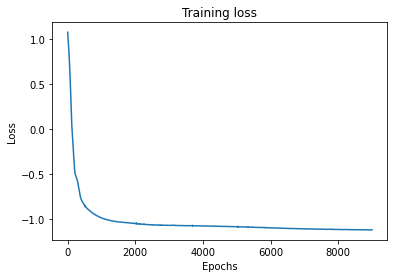

In [66]:
# Let's plot the training loss
plt.plot(range(len(losses)), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

In [67]:
# Get predictions
pi_vals, mu_vals, var_vals = model.predict(x_test)

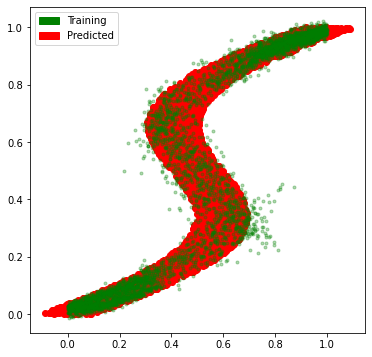

In [68]:
sampled_predictions = sample_predictions(pi_vals, mu_vals, var_vals, 1)

# Plot the predictions along with the flipped data 
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(6, 6))
plt.plot(flipped_x, flipped_y, 'ro', label='train')
for i in range(sampled_predictions.shape[1]):
     plt.plot(x_test, sampled_predictions[:, i], 'g.', alpha=0.3, label='predicted')
patches = [
    mpatches.Patch(color='green', label='Training'),
    mpatches.Patch(color='red', label='Predicted')
]
    
plt.legend(handles=patches)
plt.show()

In [69]:
sampled_predictions.shape[1]

1